In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#学習用データと評価用データの読み込み
train = pd.read_csv("./data/input/train.csv")
test = pd.read_csv("./data/output/test.csv")

In [3]:
#データのサイズ確認
print(train.shape)
print(test.shape)

(1516, 3)
(1517, 2)


In [4]:
#学習用データの中身を確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


In [5]:
#学習用データの中身を確認
train.head()

,id,description,jobflag
0,0,<li>Develop cutting-edge web applications that...,3
1,1,"<li> Designs and develops high quality, scalab...",3
2,2,<li>Functions as a point person for Network St...,4
3,3,"<li> Work on the technical design, development...",3
4,4,<li>Quantify the resources required for a task...,4


4    505
1    468
3    455
2     88
Name: jobflag, dtype: int64


<AxesSubplot:>

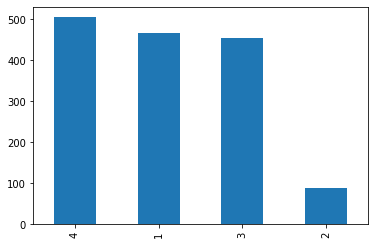

In [6]:
#学習用データに含まれるjobflagをカウント（＋可視化）
print(train['jobflag'].value_counts())
train['jobflag'].value_counts().plot(kind = 'bar')

In [7]:
#学習用データ, 評価用データのdescriptionに含まれる文字数を確認
train_length = train['description'].str.len()
test_length = test['description'].str.len()

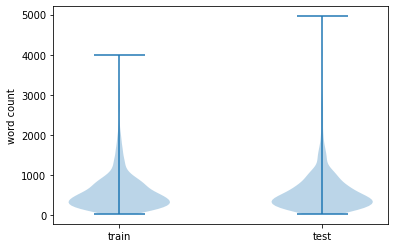

In [8]:
#可視化
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([train_length, test_length])
ax.set_xticks([1, 2])
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('word count')
plt.show()

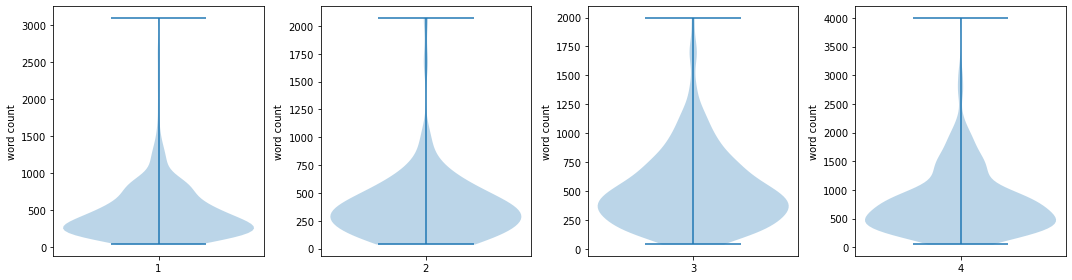

In [9]:
#学習用データの職業ラベル(jobflag)ごとの文字数を確認
fig = plt.figure(figsize = (15, 4))
for flag in [1, 2, 3, 4]:
    train_length_flag = train[train['jobflag'] == flag]['description'].str.len()
    ax = fig.add_subplot(1, 4, flag)
    ax.violinplot(train_length_flag)
    ax.set_xticks([1])
    ax.set_xticklabels([flag])
    ax.set_ylabel('word count')
plt.tight_layout()
plt.show()

In [10]:
#学習用データと評価用データを結合する (両データに対し一括で前処理を行うため)
combined = train.append(test, ignore_index=True)

In [11]:
#以下の手順でdescriptionデータのクリーニングを行う.
# <li>などのhtmlタグを削除する
# アルファベット以外の文字をスペースに置き換える
# 単語長が3文字以下のものは削除する
# ステミング（単語の語幹を取り出す作業のこと. 派生語を同じ単語として扱えるようにする）

import re
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_tag(text)
        #アルファベット以外をスペースに置き換え
        clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #単語長が3文字以下のものは削除する
        clean_short_tokenized = [word for word in clean_punc.split() if len(word) > 3]
        #ステミング
        clean_normalize = [stemmer.stem(word) for word in clean_short_tokenized]
        #単語同士をスペースでつなぎ, 文章に戻す
        clean_text = ' '.join(clean_normalize)
        clean_texts.append(clean_text)
    return clean_texts

def remove_tag(x):
    p = re.compile(r"<[^>]*?>")
    return p.sub('',x)

combined_cleaned = combined.copy()
combined_cleaned['description'] = cleaning(combined['description'])

In [12]:
# クリーニング結果の確認
print('#original\n', combined['description'][0])
print("-----")
print('#cleaned\n', combined_cleaned['description'][0])

#original
 <li>Develop cutting-edge web applications that perform superbly across all platforms.</li><li>Work in a highly collaborative environment with cross-functional teams on projects ranging from a few weeks to a few months in length.</li><li>Maintain high standard of quality as you creatively and strategically problem solve throughout the product delivery process.</li><li>Be able to effectively communicate your work with both technical and non-technical peers</li><li>Be excited about new web technologies/techniques</li><li>Build solid front-end architectures that integrate easily with other systems and technologies</li><li>Working closely with other disciplines (Back-end, UX, Design, QA)</li><li>Have a superior attention to detail and a strong ability to Q/A one\'s own work required, including cross-browser and cross-platform displays and performance</li></ul>
-----
#cleaned
 develop cut edg applic that perform superbl across platform work highli collabor environ with cross funct

In [13]:
#bag of words(文章中の単語の登場回数をカウントし, 特徴量化する手法)を用いて、descriptionをベクトル化する

from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=2000, stop_words='english')
bow = bow_vectorizer.fit_transform(combined_cleaned['description'])
print(bow.shape)

(3033, 2000)


In [14]:
#学習用データを分割して, 投稿前の精度検証を行う

from sklearn.model_selection import train_test_split

delimit_num = train.shape[0]
train_bow = bow[:delimit_num, :]
test_bow = bow[delimit_num:, :]

x_bow_train, x_bow_valid, y_bow_train, y_bow_valid = train_test_split(train_bow, train['jobflag'], test_size=0.3, random_state=0)

In [15]:
#XGBを用いて分類器を作成し、学習・予測を行う

from xgboost import XGBClassifier

mod = XGBClassifier(max_depth=6, n_estimators=1000, n_jobs=-1)
mod.fit(x_bow_train, y_bow_train)
pred = mod.predict(x_bow_valid)

              precision    recall  f1-score   support

           1      0.592     0.679     0.633       137
           2      0.429     0.136     0.207        22
           3      0.806     0.719     0.760       139
           4      0.701     0.745     0.722       157

    accuracy                          0.688       455
   macro avg      0.632     0.570     0.581       455
weighted avg      0.687     0.688     0.682       455



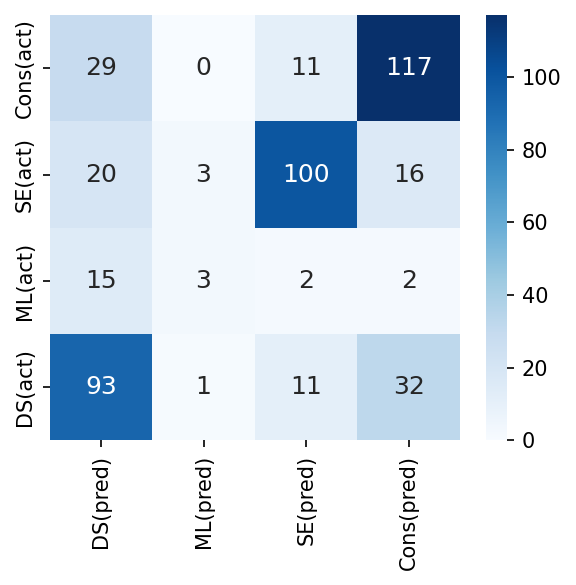

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
labels = [1, 2, 3, 4]
re_labels = ["DS", "ML", "SE", "Cons"]

#混同行列の作成
conf_mx = confusion_matrix(y_bow_valid, pred, labels=labels)
conf_df = pd.DataFrame(data=conf_mx, index=[x + "(act)" for x in re_labels], columns=[x + "(pred)" for x in re_labels])

#可視化
plt.figure(figsize=(4, 4), dpi=150)
sns.heatmap(conf_df, cmap='Blues', annot=True, fmt='d', annot_kws={"size": 12}).invert_yaxis()
plt.tight_layout()
 
print(classification_report(y_bow_valid, pred, labels=labels, digits=3))

In [17]:
#投稿用にtrain全体にて学習し、testで評価する
mod.fit(train_bow, train['jobflag'])
pred_sub = mod.predict(test_bow)

In [18]:
#投稿用のフォーマットで出力
sample_submit_df = pd.DataFrame([test['id'], pred_sub]).T
sample_submit_df.to_csv('./data/sample.csv', header=None, index=None)